In [ ]:
#############################################################################################################
# Audio-driven upper-body motion synthesis on a humanoid robot
# Computer Science Tripos Part III Project
# Jan Ondras (jo356@cam.ac.uk), Trinity College, University of Cambridge
# 2017/18
#############################################################################################################
# Evaluate synthetic speech based survey responses
# Evaluated with the survey state on 16/5/2018
#############################################################################################################

import glob
import numpy as np
import matplotlib.pyplot as plt
from evalutils import plot_training_history
from tabulate import tabulate

TTS_methods = np.array([
    'MOB', # MaryTTS, voice obadiah
    'MSP', # MaryTTS, voice spike
    'MPR', # MaryTTS, voice prudence
    'MPO'  # MaryTTS, voice poppy
])
model_types = ['LSTM_SI', 'MLP_SI']
IDs = ['6', '7', '8', '9'] # stories Banana, Picnic, Army, Glasses: http://docs.autismresearchcentre.com/papers/1999_Jolliffe_BC_Stories.pdf

scale = np.array([             # 1-5
    'Very inappropriate', 
    'Inappropriate', 
    'Neutral', 
    'Appropriate', 
    'Very appropriate'
])
#######################
# Load groundtruths: <story ID, character ID = TTS_method, position of models (0=>MLPfirst)>
gt = np.load('./../Dataset/Survey/survey_synthSpeech_groundTruths.npz')['gt'] 
print gt
######################
# Load responses: have to remove first row in Google Sheets, find&replace  and then download csv!
responses = np.loadtxt('./../Dataset/Survey/Responses/SurveyResponses_SYNTHETIC.csv', dtype='str', skiprows=0, delimiter=',') 
responses = responses[:, 1:] # skip timestamp
N_resp = responses.shape[0] # number of responses
print "Got ", N_resp, "responses.", responses.shape
# print responses

###################################
# Convert labels to numbers 1-5
responses_num = []
for r in responses:
    r_num = []
    for x in r:
        x_num = np.argwhere(scale == x)[0,0] + 1 # 1-5 scale
        r_num.append( x_num )
    responses_num.append( r_num )
responses_num = np.array(responses_num)
print responses_num

######################################################################
# Check responses: find not reliable respondents
# (1) all left are same
for ii, r in enumerate(responses_num):
    reliable = False
    for i in range(0, 32, 2):
        if i == 0:
            prev = r[i]
        else:
            if prev != r[i]:
                reliable = True
                break
    if not reliable:
        print "Respondent", ii, "not reliable: always same votes for left side"
# (2) all right are same
for ii, r in enumerate(responses_num):
    reliable = False
    for i in range(0, 32, 2):
        if i == 0:
            prev = r[i+1]
        else:
            if prev != r[i+1]:
                reliable = True
                break
    if not reliable:
        print "Respondent", ii, "not reliable: always same votes for right side"
        
######################################################################
# EXCLUDE UNRELIABLE: delete from end
responses_num = np.delete(responses_num, 30, axis = 0)
N_resp = responses_num.shape[0] # number of responses
print "AFTER EXCLUDING: Got ", N_resp, "responses.", responses_num.shape

######################################################################
# Overall MLP vs LSTM distribution

MLP_mask = []            # determines which questions were about MLP, columns in responses_num
LSTM_mask = []
for gt_i in range(16): # iterate over ground truths
    if gt[gt_i, 2] == '0':                           # MLP was on left:         MLP-LSTM
        MLP_mask.append( 2*gt_i )
        LSTM_mask.append( 2*gt_i + 1 )
    elif gt[gt_i, 2] == '1':                         # LSTM was on left:         LSTM-MLP
        MLP_mask.append( 2*gt_i + 1 )
        LSTM_mask.append( 2*gt_i )
    else:
        raise ValueError('Unknown video position!')
MLP_mask = np.array(MLP_mask)
LSTM_mask = np.array(LSTM_mask)
print MLP_mask
print LSTM_mask
responses_num_MLP = responses_num[:, MLP_mask]
responses_num_LSTM = responses_num[:, LSTM_mask]

######################################
# Alternative, equivalent calculation

MLP_distrib  = np.zeros(5) # numbers of votes for each scale item 1-5
LSTM_distrib = np.zeros(5)

for r in responses_num:
    for gt_i in range(16): # iterate over ground truths
        
        if gt[gt_i, 2] == '0':                           # MLP was on left:         MLP-LSTM
            MLP_distrib[ r[2*gt_i] - 1 ] += 1
            LSTM_distrib[ r[2*gt_i + 1] - 1 ] += 1
        elif gt[gt_i, 2] == '1':                         # LSTM was on left:         LSTM-MLP
            LSTM_distrib[ r[2*gt_i] - 1 ] += 1
            MLP_distrib[ r[2*gt_i + 1] - 1 ] += 1
        else:
            raise ValueError('Unknown video position!')
            

print MLP_distrib, np.sum(MLP_distrib)
print LSTM_distrib, np.sum(LSTM_distrib)

dataMLP = np.repeat([1,2,3,4,5], np.asarray(MLP_distrib, dtype=np.int))   # all votes
dataLSTM = np.repeat([1,2,3,4,5], np.asarray(LSTM_distrib, dtype=np.int))

# ok, equivalent 
print sorted(responses_num_MLP.flatten().tolist()) == sorted(dataMLP.tolist())
print sorted(responses_num_LSTM.flatten().tolist()) == sorted(dataLSTM.tolist())


print "dataMLP_SI_SYNTHETIC = ", dataMLP.tolist()
print "dataLSTM_SI_SYNTHETIC = ", dataLSTM.tolist()

# Save responses data for comparison with natural speech
np.savez('./../Dataset/Survey/SYNTHETIC_responses_num.npz', 
         dataMLP_SI_SYNTHETIC=dataMLP.tolist(), 
         dataLSTM_SI_SYNTHETIC=dataLSTM.tolist()
        )
    
######################################################################
# MLP vs LSTM distribution by 4 characters / personality types

MLP_distrib_byChar  = np.zeros((4, 5))
LSTM_distrib_byChar = np.zeros((4, 5))

characters = [ # ordering matches TTS_method
    'Obadiah', # MaryTTS, MOB
    'Spike',   # MaryTTS, MSP
    'Prudence',# MaryTTS, MPR
    'Poppy'    # MaryTTS, MPO
]

for r in responses_num:
    for gt_i in range(16): # iterate over ground truths
        
        char_i = np.argwhere(TTS_methods == gt[gt_i, 1])[0,0]
        
        if gt[gt_i, 2] == '0':                           # MLP was on left:         MLP-LSTM
            MLP_distrib_byChar[char_i, r[2*gt_i] - 1 ] += 1
            LSTM_distrib_byChar[char_i, r[2*gt_i + 1] - 1 ] += 1
        elif gt[gt_i, 2] == '1':                         # LSTM was on left:         LSTM-MLP
            LSTM_distrib_byChar[char_i, r[2*gt_i] - 1 ] += 1
            MLP_distrib_byChar[char_i, r[2*gt_i + 1] - 1 ] += 1
        else:
            raise ValueError('Unknown video position!')
            
print MLP_distrib_byChar, np.sum(MLP_distrib_byChar)
print LSTM_distrib_byChar, np.sum(LSTM_distrib_byChar)

dataMLP_byChar = []
for r in MLP_distrib_byChar:
    dataMLP_byChar.append( np.repeat([1,2,3,4,5], np.asarray(r, dtype=np.int)).tolist() )
dataMLP_byChar = np.array(dataMLP_byChar)

dataLSTM_byChar = []
for r in LSTM_distrib_byChar:
    dataLSTM_byChar.append( np.repeat([1,2,3,4,5], np.asarray(r, dtype=np.int)).tolist() )
dataLSTM_byChar = np.array(dataLSTM_byChar)

print dataMLP_byChar
print dataLSTM_byChar

	0.271802325581 8.44033675628e-23
	 samples A and B are significantly different


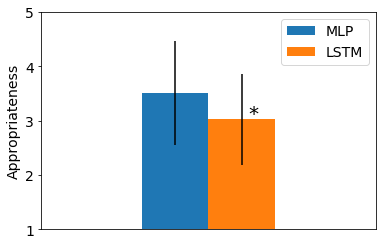

In [2]:
################################################################
# Compare MLP vs LSTM models on synthetic speech
################################################################

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

from evalutils import statistical_significance
def stat_sig_plot(dataA, dataB, y_label, data_labels, markHigher, show=True, showErr=True):
    
    meanA = np.mean(dataA)
    meanB = np.mean(dataB)
    stdA = np.std(dataA)
    stdB = np.std(dataB)
    ss = statistical_significance(dataA, dataB, 0.001, False)
    
    plt.figure()
    w = 0.2 # bar width  
    ylim_max = 0.5
    if showErr:
        plt.bar(0.-w/2., meanA, yerr=stdA, width=w, align='center', label=data_labels[0])      # bar A
        plt.bar(0.,      meanB, yerr=stdB, width=w, align='edge', label=data_labels[1])        # bar B
    else:
        plt.bar(0.-w/2., meanA, width=w, align='center', label=data_labels[0])      # bar A
        plt.bar(0.,      meanB, width=w, align='edge', label=data_labels[1])        # bar B
    ax = plt.gca()
    p = ax.patches
    if ss:
        if (meanA > meanB and markHigher) or (meanA <= meanB and not markHigher):
            # mark bar A
            i = 0
        else:
            # mark bar B
            i = 1
        ax.text(p[i].get_x()+w/1.7, p[i].get_height(), '*', fontsize=20)#, color='dimgrey')
    plt.ylabel(y_label) #, fontsize=14)
    yaxis = np.arange(5) + 1
    plt.yticks( yaxis, yaxis )
    plt.ylim( 1, 5 )
    ax.set_xticks([])
    plt.xlim(-ylim_max, ylim_max)
    plt.legend()
    if show:
        plt.show()
        
data_labels = ['MLP', 'LSTM']
stat_sig_plot(dataMLP, dataLSTM, 'Appropriateness', data_labels, 
              markHigher=False, show=True, 
              showErr=True,
#               showErr=False
             )


	0.261627906977 1.10035032392e-05
	 samples A and B are significantly different
	5.82562296456 1.33418405848e-08
	 samples A and B are significantly different
	0.313953488372 5.33766614917e-08
	 samples A and B are significantly different
	0.226744186047 0.000224161922606
	 samples A and B are significantly different


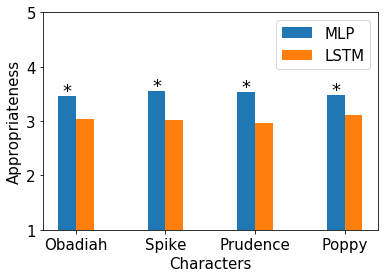

-----------------------------------------------------------------------------------------
	0.0639534883721 0.862272708144
	 samples A and B are NOT significantly different
	0.046511627907 0.990912107299
	 samples A and B are NOT significantly different
	0.0116279069767 1.0
	 samples A and B are NOT significantly different
	0.0290697674419 0.999999376156
	 samples A and B are NOT significantly different
	0.0697674418605 0.782353312373
	 samples A and B are NOT significantly different
	0.0523255813953 0.968746495855
	 samples A and B are NOT significantly different
	0.128242976886 0.898032803883
	 samples A and B are NOT significantly different
	0.75437250948 0.45114631792
	 samples A and B are NOT significantly different
	-0.814970474811 0.415657800062
	 samples A and B are NOT significantly different
	0.66082703825 0.509168944337
	 samples A and B are NOT significantly different
	-0.988204244128 0.323752905022
	 samples A and B are NOT significantly different
	-1.61297684309 0.10767189

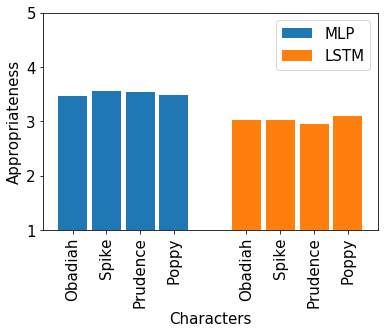

In [3]:
################################################################
# Compare models by characters
################################################################

import matplotlib
matplotlib.rcParams.update({'font.size': 15})

xaxis = np.arange(4)
w = 0.2 # bar width
# plt.figure(figsize=(7,5))
plt.figure()
plt.bar(xaxis-w, np.mean(dataMLP_byChar, axis=1), 
        #yerr=np.std(dataMLP_byChar, axis=1), 
        width=w, align='edge', label='MLP')#, color=clrs[i])
plt.bar(xaxis, np.mean(dataLSTM_byChar, axis=1), 
        #yerr=np.std(dataLSTM_byChar, axis=1), 
        width=w, align='edge', label='LSTM')#, color=clrs[i])

ax = plt.gca()
p = ax.patches    
for i in range(4):
    ss = statistical_significance(dataMLP_byChar[i], dataLSTM_byChar[i], 0.05, False)
    if ss: # is stat sig => put asterisk
        of = 0
        if np.mean(dataMLP_byChar[i]) < np.mean(dataLSTM_byChar[i]): # LSTM is better => put asterisk on it
            ax.text(p[i].get_x()+w/0.9, p[i].get_height()-of, '*', fontsize=18)
        else:
            ax.text(p[i].get_x()+w/3.9, p[i].get_height()-of, '*', fontsize=18)
        
    
plt.xticks(xaxis, characters, rotation=0)
yaxis = np.arange(5) + 1
plt.yticks( yaxis, yaxis )
plt.ylim( 1, 5 )
plt.ylabel('Appropriateness')
plt.xlabel('Characters')
# plt.xlim(-0.5, 39.5)
plt.legend()
plt.show()
print "-----------------------------------------------------------------------------------------"
#####################################################################################
# Separately for each model

shiftLSTM = 1.2
xaxis = np.linspace(0,0.7,4) 
w = 0.2 # bar width
# plt.figure(figsize=(7,5))
plt.figure()
plt.bar(xaxis, np.mean(dataMLP_byChar, axis=1), 
        #yerr=np.std(dataMLP_byChar, axis=1), 
        width=w, align='center', label='MLP')#, color=clrs[i])
plt.bar(xaxis + shiftLSTM, np.mean(dataLSTM_byChar, axis=1), 
        #yerr=np.std(dataLSTM_byChar, axis=1), 
        width=w, align='center', label='LSTM')#, color=clrs[i])

# Evaluate SS within MLP / LSTM
for i in range(4):
    for j in range(4):
        if j > i:
            ss = statistical_significance(dataMLP_byChar[i], dataMLP_byChar[j], 0.05, False)
            if ss:
                print "MLP", characters[i], characters[j]
for i in range(4):
    for j in range(4):
        if j > i:
            ss = statistical_significance(dataLSTM_byChar[i], dataLSTM_byChar[j], 0.05, False)
            if ss:
                print "LSTM", characters[i], characters[j]   

xpos = xaxis.tolist() + (xaxis + shiftLSTM).tolist()
plt.xticks(xpos, characters + characters, rotation=90)
yaxis = np.arange(5) + 1
plt.yticks( yaxis, yaxis )
plt.ylim( 1, 5 )
plt.ylabel('Appropriateness')
plt.xlabel('Characters')
plt.legend()
plt.show()